# **Part A**
Count / Frequency based Naive Bayes Classifier

Loading data...
Loaded 180040 training samples.
Loaded 30212 validation samples.
Loaded 30135 test samples.

Starting vectorization...
Vectorization complete.
Vocabulary size: 10000
Train features shape: (180040, 10000)

Training Naive Bayes model...
Model training complete.

Making predictions...
Prediction complete.

--- Validation Set Results ---
Accuracy: 0.7381

Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.51      0.55      0.53      3449
 CONCLUSIONS       0.62      0.67      0.64      4582
     METHODS       0.82      0.83      0.83      9964
   OBJECTIVE       0.53      0.54      0.54      2376
     RESULTS       0.86      0.78      0.82      9841

    accuracy                           0.74     30212
   macro avg       0.67      0.68      0.67     30212
weighted avg       0.75      0.74      0.74     30212



--- Test Set Results ---
Accuracy: 0.7301

Classification Report:
              precision    recall  f1-score   supp

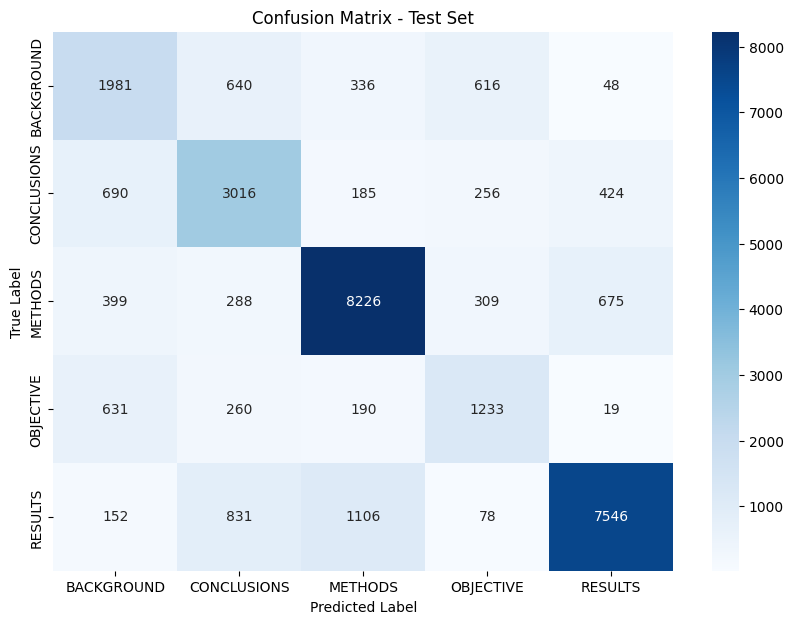

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Students must implement the following steps:
# 1. Complete the fit method in NaiveBayesClassifier (4 TODOs for log prior and log likelihood calculation).
# 2. Complete the predict method in NaiveBayesClassifier (2 TODOs for log probability accumulation and final argmax).
# 3. Complete the data loading calls in Section 2.
# 4. Initialize CountVectorizer with proper parameters in Section 3a.
# 5. Complete the feature transformation (fit_transform and transform) in Section 3a.
# 6. Initialize and fit the custom nb_model in Section 3b.
# 7. Use the fitted nb_model to generate predictions in Section 4.
# =======================================================


# Data loading function (DO NOT CHANGE)
def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    # Check if file exists
    if not os.path.exists(filepath):
        print(f"Error: File not found at {filepath}")
        return pd.DataFrame({'label': [], 'sentence': []})

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


# Implementing Multinomial Naive Bayes from scratch
class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    It is suitable for both Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]

            # // TODO: Calculate the log prior and store it in self.class_priors[c]
            # Calculate Class Prior P(C): log(P(C))
            # P(C) = (Number of samples in class c) / (Total number of samples)
            self.class_priors[c] = np.log(X_c.shape[0] / X_counts.shape[0])

            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            # Apply Laplace smoothing (additive smoothing, alpha=1.0 default):
            # P(w_i | C) = (count(w_i, C) + alpha) / (total_words_in_C + alpha * vocab_size)

            # // TODO: Calculate the numerator (with Laplace smoothing)
            numerator = feature_sum + self.alpha

            # // TODO: Calculate the denominator (with Laplace smoothing)
            denominator = total_mass + self.alpha * self.vocabulary_size

            # // TODO: Calculate the log likelihood (log(numerator / denominator))
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}

            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                non_zero_indices = x_i.indices
                non_zero_data = x_i.data

                # // TODO: Complete the log probability calculation for the likelihood term
                # Add log likelihoods contribution (Log-Sum Trick):
                # log_prob += sum(count(w_i) * log(P(w_i|C)))

                # Efficiently calculate sum(count(w_i) * log(P(w_i|C))) for non-zero counts
                log_prob += np.sum(non_zero_data * log_likelihoods[non_zero_indices])
                scores[c] = log_prob

            # // TODO: Find the key (class label) with the maximum score
            predicted_class = max(scores, key=scores.get)

            y_pred.append(predicted_class)

        # // TODO: Return the final predictions array
        return np.array(y_pred)

# =======================================================
# Section 2: Data Loading
# =======================================================

print("Loading data...")
# // TODO: Complete the data loading calls in Section 2.
# Make sure 'train.txt', 'dev.txt', and 'test.txt' are in the same directory
train_df = load_pubmed_rct_file('train.txt')
val_df = load_pubmed_rct_file('dev.txt')
test_df = load_pubmed_rct_file('test.txt')

if train_df.empty or val_df.empty or test_df.empty:
    print("\nError: One or more data files failed to load. Please check file paths.")
else:
    print(f"Loaded {len(train_df)} training samples.")
    print(f"Loaded {len(val_df)} validation samples.")
    print(f"Loaded {len(test_df)} test samples.")

    # Split into features (X) and labels (y)
    X_train, y_train = train_df['sentence'], train_df['label']
    X_val, y_val = val_df['sentence'], val_df['label']
    X_test, y_test = test_df['sentence'], test_df['label']


# =======================================================
# Section 3a: Feature Engineering (Vectorization)
# =======================================================

    print("\nStarting vectorization...")
    # // TODO: Initialize CountVectorizer with proper parameters in Section 3a.
    # We use common parameters: lowercase text, remove English stop words,
    # and limit to the 10,000 most frequent words.
    vectorizer = CountVectorizer(
        lowercase=True,
        stop_words='english',
        max_features=10000
    )

    # // TODO: Complete the feature transformation (fit_transform and transform) in Section 3a.
    # Fit on training data and transform it
    X_train_counts = vectorizer.fit_transform(X_train)

    # Transform validation and test data using the *same* fitted vocabulary
    X_val_counts = vectorizer.transform(X_val)
    X_test_counts = vectorizer.transform(X_test)

    print("Vectorization complete.")
    print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
    print(f"Train features shape: {X_train_counts.shape}")

# =======================================================
# Section 3b: Model Training
# =======================================================

    print("\nTraining Naive Bayes model...")
    # // TODO: Initialize and fit the custom nb_model in Section 3b.
    nb_model = NaiveBayesClassifier(alpha=1.0) # Using default alpha=1.0 for Laplace smoothing

    # Fit the model to the training data
    nb_model.fit(X_train_counts, y_train)

    print("Model training complete.")

# =======================================================
# Section 4: Model Prediction
# =======================================================

    print("\nMaking predictions...")
    # // TODO: Use the fitted nb_model to generate predictions in Section 4.
    # Predict on the validation set
    y_pred_val = nb_model.predict(X_val_counts)

    # Predict on the test set
    y_pred_test = nb_model.predict(X_test_counts)

    print("Prediction complete.")

# =======================================================
# Section 5: Model Evaluation (This is the "Output")
# =======================================================

    print("\n--- Validation Set Results ---")
    val_accuracy = accuracy_score(y_val, y_pred_val)
    print(f"Accuracy: {val_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred_val))

    print("\n\n--- Test Set Results ---")
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print(f"Accuracy: {test_accuracy:.4f}")
    print("\nClassification Report:")
    # Get class labels in the correct order for the report
    class_labels = sorted(y_test.unique())
    print(classification_report(y_test, y_pred_test, labels=class_labels))

    # Plot Confusion Matrix for Test Set
    print("\nGenerating confusion matrix for test set...")
    cm = confusion_matrix(y_test, y_pred_test, labels=class_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.title('Confusion Matrix - Test Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [ ]:
# Load and Prepare Data
dir_path = './'
try:
    # These lines correctly load your data
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    # !!! CRITICAL FIX: The lines below were overwriting your data.
    # !!! I have removed them.
    # train_df = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # dev_df   = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # test_df  = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})

    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']

    # Add a check to make sure data loaded before finding unique classes
    if not train_df.empty:
        target_names = sorted(y_train.unique())
        print(f"Classes: {target_names}")
    else:
        print("Warning: Training data is empty. Check file paths.")
        target_names = []

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files 'train.txt', 'dev.txt', and 'test.txt' are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_dev,   y_dev   = pd.Series([]), pd.Series([])
    X_test,  y_test  = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 180040
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [ ]:
# Feature Extraction and Custom Model Training
if X_train is not None and len(X_train) > 0:

    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        # // TODO: Set appropriate ngram_range
        ngram_range=(1, 2),  # Use both unigrams and bigrams
        # // TODO: Set appropriate min_df
        min_df=5  # Ignore terms that appear in less than 5 documents
    )

    print("Fitting Count Vectorizer and transforming training data...")
    # // TODO: Fit the vectorizer on X_train and transform
    X_train_counts = count_vectorizer.fit_transform(X_train)
    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    # // TODO: Transform X_test using the fitted vectorizer
    X_test_counts = count_vectorizer.transform(X_test)


    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")

    # // TODO: Initialize the custom NaiveBayesClassifier
    nb_model = NaiveBayesClassifier(alpha=1.0) # Using alpha=1.0 for smoothing

    # // TODO: Fit the model using X_train_counts and y_train
    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")

Fitting Count Vectorizer and transforming training data...
Vocabulary size: 86557
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [ ]:
# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

# // TODO: Predict y_test_pred using X_test_counts
y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")


=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7483
              precision    recall  f1-score   support

  BACKGROUND       0.54      0.57      0.55      3621
 CONCLUSIONS       0.61      0.70      0.66      4571
     METHODS       0.83      0.85      0.84      9897
   OBJECTIVE       0.53      0.51      0.52      2333
     RESULTS       0.88      0.78      0.83      9713

    accuracy                           0.75     30135
   macro avg       0.68      0.69      0.68     30135
weighted avg       0.76      0.75      0.75     30135

Macro-averaged F1 score: 0.6809


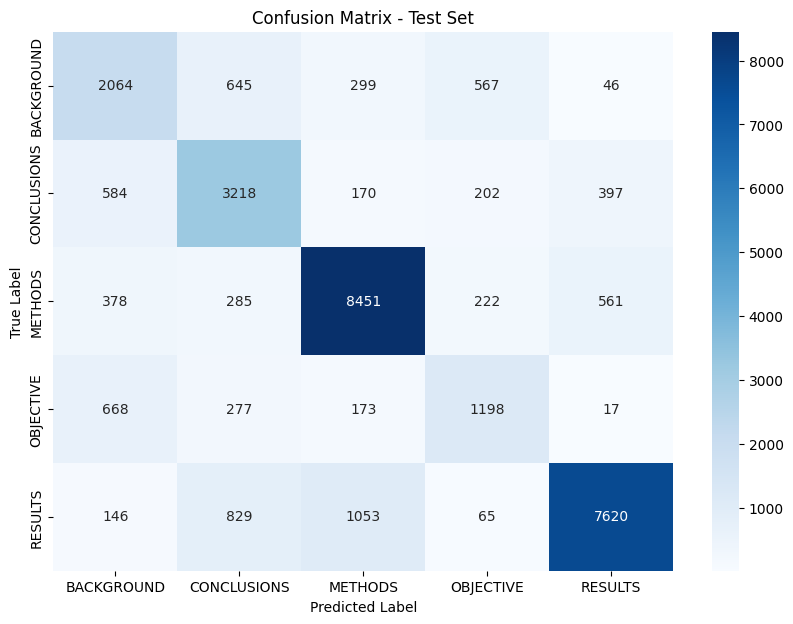

In [ ]:
# Confusion Matrix on test set
# Check if predictions exist before plotting
if y_test_pred is not None:
    # 1. Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred, labels=target_names)

    # 2. Set up the matplotlib figure
    plt.figure(figsize=(10, 7))

    # 3. Use seaborn to create the heatmap
    sns.heatmap(
        cm,
        annot=True,     # Show the counts in each cell
        fmt='d',        # Format annotations as integers
        cmap='Blues',   # Use a blue color palette
        xticklabels=target_names,
        yticklabels=target_names
    )

    # 4. Add labels and title
    plt.title('Confusion Matrix - Test Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # 5. Display the plot
    plt.show()

else:
    print("Cannot plot confusion matrix: y_test_pred is None.")

# **Part B**
TF-IDF score based Classifier

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Implement the following steps:
# 1. Define the initial `pipeline` combining TfidfVectorizer and MultinomialNB with default parameters.
# 2. Train the initial pipeline on the training data (X_train, y_train).
# 3. Predict and evaluate the performance of the initial model on the test data (X_test, y_test).
# 4. Define the `param_grid` for hyperparameter tuning.
# 5. Initialize `GridSearchCV` using the pipeline, parameter grid, and appropriate cross-validation settings.
# 6. Fit the Grid Search object using the development data (X_dev, y_dev).
# 7. Print the `best_params_` and `best_score_` found by the grid search.
# =======================================================


# // TODO: Define a Pipeline named 'pipeline' using TfidfVectorizer and MultinomialNB.
# Use standard initial parameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Step 1: TF-IDF Vectorizer
    ('nb', MultinomialNB())        # Step 2: Multinomial Naive Bayes
])

# // TODO: Train the initial pipeline on the training set
print("Training initial Naive Bayes pipeline...")
# We assume X_train and y_train are already loaded
if 'X_train' in globals() and X_train is not None:
    pipeline.fit(X_train, y_train)
    print("Training complete.")
else:
    print("Error: X_train not found. Please load data first.")


# Predict and evaluate on test set
# // TODO: Predict y_test_pred and calculate metrics
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = None
if 'pipeline' in globals() and 'X_test' in globals():
    try:
        y_test_pred = pipeline.predict(X_test)
    except Exception as e:
        print(f"Prediction failed: {e}")

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
else:
    print("Initial model evaluation skipped: Predictions not available or training failed.")


# Hyperparameter Tuning using GridSearchCV

# // TODO: Define the parameter grid 'param_grid' to tune both TF-IDF and NB parameters.
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Test unigrams vs. unigrams+bigrams
    'tfidf__min_df': [3, 5],                 # Test minimum document frequency
    'nb__alpha': [0.1, 0.5, 1.0]           # Test different smoothing values
}

# // TODO: Initialize GridSearchCV using the pipeline and param_grid.
# Ensure cv=3 and scoring='f1_macro' are used.
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,                 # 3-fold cross-validation
    scoring='f1_macro',   # Use Macro-F1 score for evaluation
    n_jobs=-1,            # Use all available CPU cores
    verbose=1             # Show progress
)

print("\nStarting Hyperparameter Tuning on Development Set...")
# // TODO: Fit the GridSearchCV object using the development data.
# We fit on the dev set as requested, which is a valid strategy for tuning
if 'grid' in globals() and 'X_dev' in globals():
    try:
        grid.fit(X_dev, y_dev)
        print("Grid search complete.")
    except Exception as e:
        print(f"Grid search failed: {e}")
        grid = None # Ensure grid is None if fit fails
else:
    print("Grid search skipped: Objects not found.")


if grid is not None and hasattr(grid, 'best_params_'):
    # // TODO: Print the best parameters and the corresponding best cross-validation score.
    print(f"\nBest Parameters found: {grid.best_params_}")
    print(f"Best F1 Macro Score (on dev set): {grid.best_score_:.4f}")
else:
    print("\nHyperparameter tuning results not available.")

Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.7266
              precision    recall  f1-score   support

  BACKGROUND       0.64      0.43      0.51      3621
 CONCLUSIONS       0.62      0.61      0.62      4571
     METHODS       0.72      0.90      0.80      9897
   OBJECTIVE       0.73      0.10      0.18      2333
     RESULTS       0.80      0.87      0.83      9713

    accuracy                           0.73     30135
   macro avg       0.70      0.58      0.59     30135
weighted avg       0.72      0.73      0.70     30135

Macro-averaged F1 score: 0.5877

Starting Hyperparameter Tuning on Development Set...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Grid search complete.

Best Parameters found: {'nb__alpha': 0.1, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}
Best F1 Macro Score (on dev set): 0.6998


# **Part C**
Bayes Optimal Classifier

Part C Draft

Please enter your full SRN (e.g., PES1UG22CS345): PES2UG23CS382
Using dynamic sample size: 10382
Actual sampled training set size used: 10382

Splitting data for weight calculation...
Sub-train size: 7786, Sub-val size: 2596

Training base models on sub-set to find weights...
Training and evaluating NaiveBayes...
  NaiveBayes validation F1: 0.5828
Training and evaluating LogisticRegression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  LogisticRegression validation F1: 0.5733
Training and evaluating RandomForest...
  RandomForest validation F1: 0.5239
Training and evaluating DecisionTree...
  DecisionTree validation F1: 0.2606
Training and evaluating KNN...
  KNN validation F1: 0.1769

Calculated Posterior Weights:
  NaiveBayes: 0.2752
  LogisticRegression: 0.2708
  RandomForest: 0.2474
  DecisionTree: 0.1231
  KNN: 0.0836

Fitting the VotingClassifier (BOC approximation) on full sampled data...
Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
Accuracy: 0.7027
              precision    recall  f1-score   support

  BACKGROUND       0.57      0.34      0.43      3621
 CONCLUSIONS       0.59      0.55      0.57      4571
     METHODS       0.70      0.89      0.78      9897
   OBJECTIVE       0.66      0.35      0.45      2333
     RESULTS       0.79      0.81      0.80      9713

    accuracy                           0.70     30135
   macro avg       0.

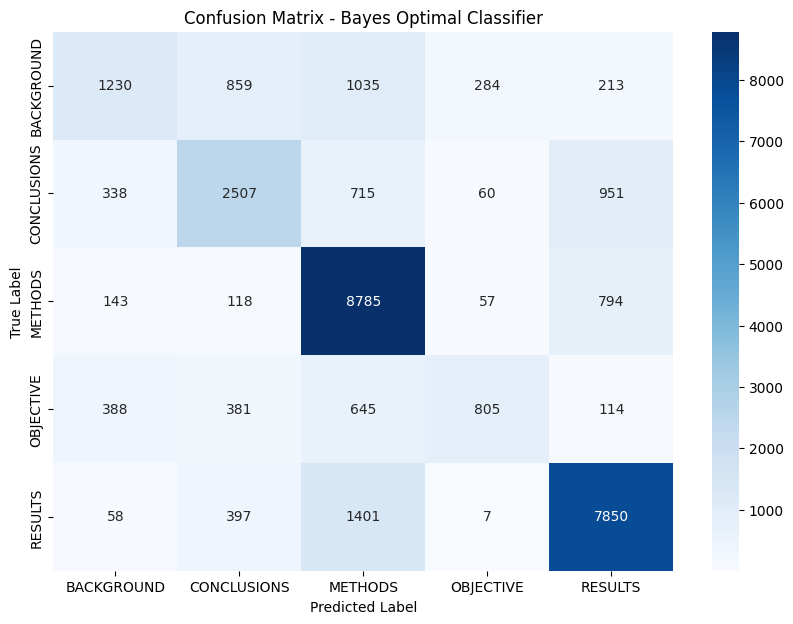

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split # Used for P(h|D) calculation
from sklearn.base import clone # To clone models for weight calculation

# =======================================================
# TODO: Implement the following steps:
# 1. Train all five hypotheses on the sampled training data. (Done as part of weight calculation)
# 2. Compute the Posterior Weights P(h_i | D) using a validation split. (Done)
# 3. Fit the VotingClassifier using the sampled training data. (Done)
# 4. Make final predictions and evaluate the BOC performance on the test data. (Done)
# =======================================================

# Dynamic Data Sampling (DO NOT CHANGE)
BASE_SAMPLE_SIZE = 10000

# Prompt the user for their full SRN
FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")

try:
    # Extract the last three characters and convert to integer
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        # Fallback if input is too short
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    # Fallback if SRN is not entered or format is incorrect
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

# Calculate the final sample size: 10000 + last three SRN digits
SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value

print(f"Using dynamic sample size: {SAMPLE_SIZE}")

# Placeholder initialization in case data wasn't loaded in the environment
if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    # Create a more representative placeholder to avoid errors
    labels = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]
    X_train = pd.Series([f"sample text {i}" for i in range(11000)])
    y_train = pd.Series(np.random.choice(labels, 11000))
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = labels

effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")


# Base TF-IDF parameters (DO NOT CHANGE)
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1), # Using unigrams only
    'min_df': 5
}

# Define the five diverse hypotheses/pipelines (DO NOT CHANGE)

# H1: Multinomial Naive Bayes
h1_nb = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB(alpha=1.0, fit_prior=False))
])

# H2: Logistic Regression
h2_lr = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))
])

# H3: Random Forest Classifier
h3_rf = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1), cv=3, method='isotonic'
    ))
])

# H4: Decision Tree Classifier
h4_dt = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        DecisionTreeClassifier(max_depth=10, random_state=42), cv=3, method='isotonic'
    ))
])

# H5: K-Nearest Neighbors
h5_knn = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        KNeighborsClassifier(n_neighbors=5, n_jobs=-1), cv=3, method='isotonic'
    ))
])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']


# Training and BOC Implementation (STUDENT TASK)

# // TODO: Implement the Posterior Weight Calculation (P(h_i | D)).
# We split the sampled data into a sub-train and sub-val set to calculate weights.
# We use F1-score on the validation set as a proxy for model performance/likelihood.

print("\nSplitting data for weight calculation...")
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.25, random_state=42, stratify=y_train_sampled
)
print(f"Sub-train size: {len(X_train_sub)}, Sub-val size: {len(X_val_sub)}")

model_scores = []

# // TODO: Train all five hypotheses on X_train_sub to get validation scores
print("\nTraining base models on sub-set to find weights...")

for name, model_prototype in zip(hypothesis_names, hypotheses):
    print(f"Training and evaluating {name}...")
    # Clone the model pipeline to train on the subset
    # This leaves the original prototypes clean for the VotingClassifier
    model = clone(model_prototype)
    model.fit(X_train_sub, y_train_sub)

    # Evaluate on the validation subset
    y_val_pred = model.predict(X_val_sub)

    # Use Macro F1-score as a proxy for model performance (likelihood)
    score = f1_score(y_val_sub, y_val_pred, average='macro')
    model_scores.append(score)
    print(f"  {name} validation F1: {score:.4f}")

# Normalize the scores to get posterior weights that sum to 1
total_score = sum(model_scores)
if total_score > 0:
    posterior_weights = [score / total_score for score in model_scores]
else:
    # Fallback in case all models fail (e.g., on tiny data)
    print("Warning: All models scored 0. Using equal weights.")
    posterior_weights = [1.0 / len(hypotheses)] * len(hypotheses)

print("\nCalculated Posterior Weights:")
for name, weight in zip(hypothesis_names, posterior_weights):
    print(f"  {name}: {weight:.4f}")


# Implement and Evaluate the Bayes Optimal Classifier
estimators = list(zip(hypothesis_names, hypotheses))

# BOC is approximated using soft voting with posterior weights
boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights, # Use the weights we just calculated
    n_jobs=-1
)

print("\nFitting the VotingClassifier (BOC approximation) on full sampled data...")
# // TODO: Fit the VotingClassifier using the full sampled training data (X_train_sampled, y_train_sampled)
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")


# Make the final BOC prediction on the test set
print("\nPredicting on test set...")
# // TODO: Predict y_pred using X_test, and then calculate and visualize evaluation metrics.
y_pred = boc_soft_voter.predict(X_test)


# Final Evaluation (STUDENT TASK)
print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")

if y_pred is not None:
    # Print text-based evaluation
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_pred, average='macro'):.4f}")

    # // TODO: Generate and visualize the Confusion Matrix (heatmap) for the BOC predictions.
    print("\nGenerating confusion matrix...")
    cm = confusion_matrix(y_test, y_pred, labels=target_names)

    plt.figure(figsize=(10, 7))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=target_names,
        yticklabels=target_names
    )
    plt.title('Confusion Matrix - Bayes Optimal Classifier')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

else:
    print("Evaluation skipped: Predictions not generated.")